# Heart Disease Risk Prediction

In [ ]:
# link to your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import csv

project_dir = '/content/drive/My Drive/APS360 Project'

with open(project_dir + '/heart_data_v2.csv','r') as csvfile:
    data_reader = csv.reader(csvfile)

    data_orig = []
    for row in data_reader:
        if len(data_orig) > 0:
            row = [float(x) for x in row]
        data_orig.append(row)

print("Number of samples:", len(data_orig[1:]))

Number of samples: 918


In [ ]:
# display the first 5 rows
data_orig[0][0] = 'ID'

for i in range(5):
    print(data_orig[i])

['ID', 'Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope', 'HeartDisease']
[0.0, 40.0, 0.0, 2.0, 140.0, 289.0, 0.0, 0.0, 172.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 49.0, 1.0, 3.0, 160.0, 180.0, 0.0, 0.0, 156.0, 0.0, 1.0, 1.0, 1.0]
[2.0, 37.0, 0.0, 2.0, 130.0, 283.0, 0.0, 1.0, 98.0, 0.0, 0.0, 0.0, 0.0]
[3.0, 48.0, 1.0, 0.0, 138.0, 214.0, 0.0, 0.0, 108.0, 1.0, 1.5, 1.0, 1.0]


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

data_without_attr = np.array(data_orig[1:])
np.random.shuffle(data_without_attr)
data_numpy = np.array(data_without_attr[:, 1:-1], dtype="f")
label_numpy = np.array(data_without_attr[:, -1], dtype="l")

# Normalizing data between [0,1] using min-max scaling
data_normed = (data_numpy - data_numpy.min(0)) / data_numpy.ptp(0)

nrmlz = True
if nrmlz:
  data_torch = torch.from_numpy(data_normed)
else:
  data_torch = torch.from_numpy(data_numpy)

label_torch = torch.from_numpy(label_numpy)

dataset = torch.utils.data.TensorDataset(data_torch, label_torch)
length = len(dataset)

train_data = torch.utils.data.Subset(dataset, np.arange(0, int(length*0.8)))
val_data = torch.utils.data.Subset(dataset, np.arange(int(length*0.8), int(length*0.9)))
test_data = torch.utils.data.Subset(dataset, np.arange(int(length*0.9), length))
use_cuda = False

print('Total number of samples:', length)
print('Number of training samples:', len(train_data))
print('Number of validation samples:', len(val_data))
print('Number of testing samples:', len(test_data))

Total number of samples: 918
Number of training samples: 734
Number of validation samples: 92
Number of testing samples: 92


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim #for gradient descent

class ArtificialNeuralNetwork(nn.Module):
    def __init__(self, activation=F.relu):
        super(ArtificialNeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(11, 32)
        self.fc2 = nn.Linear(32, 128)
        self.fc3 = nn.Linear(128, 2)
        self.activation = activation
        self.name = 'ann'

    def forward(self, input):
        x = input.view(-1, 11)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    for samples, labels in data_loader:
         
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          samples = samples.cuda()
          labels = labels.cuda()
        #############################################
        
        output = model(samples)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += samples.shape[0]
    return correct / total

In [ ]:
def train(model, batch_size=16, learning_rate=0.001, num_epochs=50):
    # for reproducibility
    torch.manual_seed(1)

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    #optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for samples, labels in iter(train_loader):
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
                samples = samples.cuda()
                labels = labels.cuda()
            #############################################
            
            out = model(samples)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            iters.append(n)
            losses.append(float(loss)) # compute *total* loss
            n += 1

        print('epoch {}:'.format(epoch), end=' ')
        train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy 
        val_acc.append(get_accuracy(model, val_loader))     # compute validation accuracy
        print('train accuracy {:.3f}%, validation accuracy {:.3f}%'.format(train_acc[-1]*100, val_acc[-1]*100))

    epochs = np.arange(1,num_epochs +1)

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, val_acc, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

epoch 0: train accuracy 83.106%, validation accuracy 88.043%
epoch 1: train accuracy 83.651%, validation accuracy 85.870%
epoch 2: train accuracy 84.196%, validation accuracy 84.783%
epoch 3: train accuracy 85.831%, validation accuracy 85.870%
epoch 4: train accuracy 85.422%, validation accuracy 84.783%
epoch 5: train accuracy 87.057%, validation accuracy 85.870%
epoch 6: train accuracy 87.057%, validation accuracy 85.870%
epoch 7: train accuracy 87.330%, validation accuracy 85.870%
epoch 8: train accuracy 86.785%, validation accuracy 85.870%
epoch 9: train accuracy 87.330%, validation accuracy 88.043%
epoch 10: train accuracy 87.602%, validation accuracy 88.043%
epoch 11: train accuracy 87.466%, validation accuracy 88.043%
epoch 12: train accuracy 85.831%, validation accuracy 85.870%
epoch 13: train accuracy 86.649%, validation accuracy 85.870%
epoch 14: train accuracy 87.330%, validation accuracy 88.043%
epoch 15: train accuracy 87.330%, validation accuracy 86.957%
epoch 16: train ac

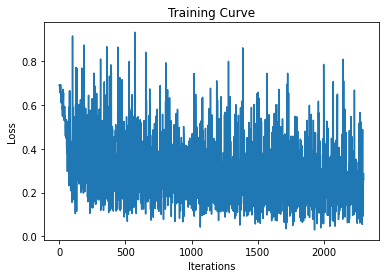

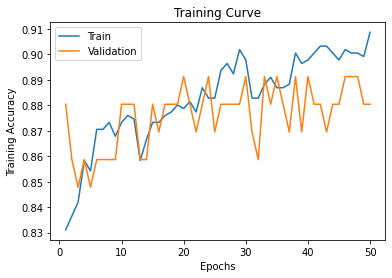

In [ ]:
ann = ArtificialNeuralNetwork()
if use_cuda and torch.cuda.is_available():
    ann.cuda()

train(ann)

# Tuning

Adam out perform the other optimizers as per below
- Adagrad
- RAdam
- RMSprop
- Adadelta
- ASGD
- SGD

Relu outperform the rest activation functions including
- Relu6
- Relu_leaky
- logsigmoid

Best learning rate is at around 0.002 and Batch Size is 8. Epoch to be 50

In [ ]:
def train(model, batch_size=16, learning_rate=0.001, num_epochs=50):
    # for reproducibility
    torch.manual_seed(1)

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    #optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)
    #optimizer = optim.RAdam(model.parameters(), lr=learning_rate)
    #optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, )
    #optimizer = optim.Adadelta(model.parameters(), lr=learning_rate)
    #optimizer = optim.ASGD(model.parameters(), lr=learning_rate)
    #optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for samples, labels in iter(train_loader):
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
                samples = samples.cuda()
                labels = labels.cuda()
            #############################################
            
            out = model(samples)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            iters.append(n)
            losses.append(float(loss)) # compute *total* loss
            n += 1

        print('{}'.format('#'), end='')
        train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy 
        val_acc.append(get_accuracy(model, val_loader))     # compute validation accuracy
        #print('train accuracy {:.3f}%, validation accuracy {:.3f}%'.format(train_acc[-1]*100, val_acc[-1]*100))

    epochs = np.arange(1,num_epochs +1)

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, val_acc, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()
    print('train accuracy {:.3f}%, validation accuracy {:.3f}%'.format(train_acc[-1]*100, val_acc[-1]*100))


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim #for gradient descent

class NewANN(nn.Module):
    def __init__(self, activation=F.relu):
        super(NewANN, self).__init__()
        H1 = 20
        H2 = 50
        H3 = 2
        
        self.fc1 = nn.Linear(11, H1)
        self.fc2 = nn.Linear(H1, H2)
        self.fc3 = nn.Linear(H2, H3)
        #self.fc4 = nn.Linear(H3, H4)
        self.activation = activation
        self.name = 'new'

    def forward(self, input):
        x = input.view(-1, 11)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        # x = self.fc2(x)
        # x = self.activation(self.fc3(x))
        x = self.fc3(x)
        # x = self.fc4(x)
        return x

##################################################

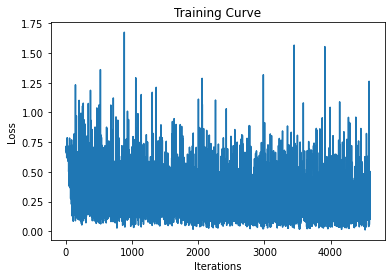

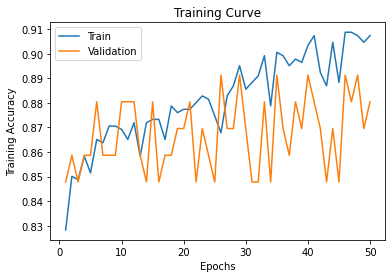

train accuracy 90.736%, validation accuracy 88.043%


In [ ]:
ann = NewANN(F.relu6)
#ann = NewANN(F.leaky_relu)
#ann = NewANN(F.logsigmoid)

#ann = NewANN()
if use_cuda and torch.cuda.is_available():
    ann.cuda()

train(ann, learning_rate=0.002, batch_size=8, num_epochs=50)


# A new model, and a look into RNG

## Keyang's conclusions and comments

> ReLu6() works surprisingly well as an activation function

> Batch size should be relatively small (~10), learning rate should be something around 1e-3

> **IMPORTANT**: RNG between sessions differ, therefore it's hard to find a set of hyperparameters that consistently trains high-acc (>90% validation accuracy) models

> As a result of RNG it's hard to say how many hidden layers and units we need in the baseline model

> However since the dataset is small and easy to compute, we should use more epochs and take our time

In [ ]:
# link to your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import csv

project_dir = '/content/drive/MyDrive/APS360 Project'

with open(project_dir + '/heart_data_v2.csv','r') as csvfile:
    data_reader = csv.reader(csvfile)

    data_orig = []
    for row in data_reader:
        if len(data_orig) > 0:
            row = [float(x) for x in row]
        data_orig.append(row)

print("Number of samples:", len(data_orig[1:]))

Number of samples: 918


In [ ]:
import time

def train(model, batch_size=16, learning_rate=0.001, num_epochs=50):
    # for reproducibility
    torch.manual_seed(1)

    start = time.time()
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    #optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for samples, labels in iter(train_loader):
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
                samples = samples.cuda()
                labels = labels.cuda()
            #############################################
            
            out = model(samples)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            iters.append(n)
            losses.append(float(loss)) # compute *total* loss
            n += 1


        ta = get_accuracy(model, train_loader)
        va = get_accuracy(model, val_loader)
        train_acc.append(ta) # compute training accuracy 
        val_acc.append(va)     # compute validation accuracy
        if ta > 0.9 or va > 0.9:
            print('epoch {}:'.format(epoch), end=' ')
            print('train accuracy {:.3f}%, validation accuracy {:.3f}%'.format(train_acc[-1]*100, val_acc[-1]*100))

    elapsed = time.time() - start
    epochs = np.arange(1,num_epochs +1)

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, val_acc, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final train acc: ", train_acc[-1])
    print("Final validation acc: ", val_acc[-1])
    print("TTE: {:.3f}s".format(elapsed))

In [ ]:
H1 = 32
H2 = 128
H3 = 4
H4 = 4

class AnotherArtificialNeuralNetwork(nn.Module):
    def __init__(self, activation=F.relu):
        super(AnotherArtificialNeuralNetwork, self).__init__()
        
        self.fc1 = nn.Linear(11, H1)
        self.fc2 = nn.Linear(H1, H2)
        self.fc3 = nn.Linear(H2, H3)
        #self.fc4 = nn.Linear(H3, H4)
        self.activation = activation
        self.name = 'another'

    def forward(self, input):
        x = input.view(-1, 11)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        # x = self.fc2(x)
        # x = self.activation(self.fc3(x))
        x = self.fc3(x)
        # x = self.fc4(x)
        return x

## Visual evidence on RNG issue

epoch 28: train accuracy 90.327%, validation accuracy 86.957%
epoch 34: train accuracy 90.463%, validation accuracy 86.957%
epoch 35: train accuracy 90.327%, validation accuracy 86.957%
epoch 39: train accuracy 90.327%, validation accuracy 85.870%
epoch 40: train accuracy 90.054%, validation accuracy 86.957%
epoch 41: train accuracy 90.872%, validation accuracy 85.870%
epoch 42: train accuracy 90.736%, validation accuracy 86.957%
epoch 43: train accuracy 90.327%, validation accuracy 86.957%
epoch 45: train accuracy 90.191%, validation accuracy 88.043%
epoch 46: train accuracy 91.008%, validation accuracy 86.957%
epoch 47: train accuracy 90.327%, validation accuracy 89.130%
epoch 48: train accuracy 90.327%, validation accuracy 85.870%
epoch 49: train accuracy 90.599%, validation accuracy 88.043%
epoch 51: train accuracy 91.553%, validation accuracy 88.043%
epoch 52: train accuracy 91.417%, validation accuracy 86.957%
epoch 53: train accuracy 90.463%, validation accuracy 88.043%
epoch 54

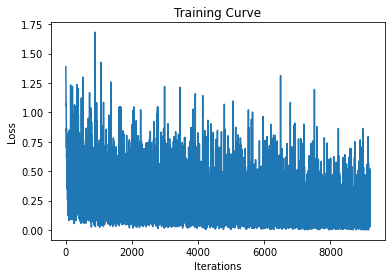

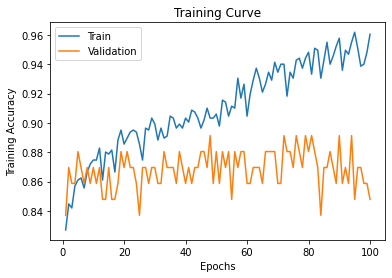

Final train acc:  0.9604904632152589
Final validation acc:  0.8478260869565217
TTE: 10.359s


In [ ]:
# fun = F.relu
fun = F.relu6
# fun = F.logsigmoid
# fun = F.leaky_relu

anotherANN = AnotherArtificialNeuralNetwork(fun)
if use_cuda and torch.cuda.is_available():
    anotherANN.cuda()

# train(anotherANN)
train(anotherANN, batch_size = 8, learning_rate = 0.002, num_epochs = 100)

epoch 28: train accuracy 90.599%, validation accuracy 89.130%
epoch 29: train accuracy 89.918%, validation accuracy 90.217%
epoch 32: train accuracy 90.463%, validation accuracy 90.217%
epoch 34: train accuracy 90.191%, validation accuracy 89.130%
epoch 35: train accuracy 89.782%, validation accuracy 90.217%
epoch 39: train accuracy 90.463%, validation accuracy 90.217%
epoch 40: train accuracy 90.463%, validation accuracy 89.130%
epoch 41: train accuracy 90.191%, validation accuracy 90.217%
epoch 43: train accuracy 90.599%, validation accuracy 89.130%
epoch 44: train accuracy 90.054%, validation accuracy 86.957%
epoch 45: train accuracy 90.054%, validation accuracy 89.130%
epoch 46: train accuracy 90.736%, validation accuracy 89.130%
epoch 47: train accuracy 91.417%, validation accuracy 90.217%
epoch 48: train accuracy 90.327%, validation accuracy 86.957%
epoch 49: train accuracy 90.327%, validation accuracy 88.043%
epoch 51: train accuracy 91.689%, validation accuracy 90.217%
epoch 52

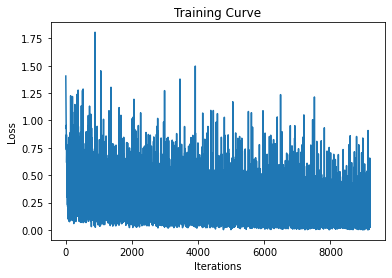

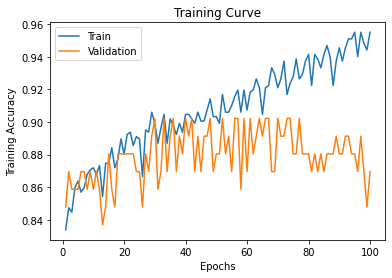

Final train acc:  0.9550408719346049
Final validation acc:  0.8695652173913043
TTE: 10.557s


In [ ]:
####################################################
'''
THIS BLOCK OF CODE IS EXACTLY THE SAME AS THE LAST ONE.
USED TO DEMONSTRATE HOW RNG BETWEEN SESSIONS
CAN AFFECT TRAINING PERFORMANCE OF A MODEL
UNDER EXACTLY THE SAME HYPERPARAMETERS.
'''
####################################################


# fun = F.relu
fun = F.relu6
# fun = F.logsigmoid
# fun = F.leaky_relu

anotherANN = AnotherArtificialNeuralNetwork(fun)
if use_cuda and torch.cuda.is_available():
    anotherANN.cuda()

# train(anotherANN)
train(anotherANN, batch_size = 8, learning_rate = 0.002, num_epochs = 100)

In [ ]:
def get_confusion_matrix(model, data_loader):
    confusion_matrix = {'tp': 0, 'fp': 0, 'fn': 0, 'tn': 0}

    for samples, labels in data_loader:
         
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          samples = samples.cuda()
          labels = labels.cuda()
        #############################################
        
        output = model(samples)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        # print(pred)
        # print(labels.view_as(pred))

        for i in range(len(pred)):
            prediction = pred[i]
            truth = labels.view_as(pred)[i]
            if prediction == 1 and truth == 1:
                confusion_matrix['tp'] += 1
            elif prediction == 1 and truth == 0:
                confusion_matrix['fp'] += 1
            elif prediction == 0 and truth == 0:
                confusion_matrix['tn'] += 1
            else:
                confusion_matrix['fn'] += 1
        
    return confusion_matrix

In [ ]:
def print_score(cm):
    acc = (cm['tp'] + cm['tn']) / sum(cm.values())
    pre = cm['tp'] / (cm['tp'] + cm['fp'])
    rec = cm['tp'] / (cm['tp'] + cm['fn'])
    f1_score = 2 * pre * rec / (pre + rec)

    print("Test Accuracy: {:.3f}%".format(acc*100))
    print("Test Precision: {:.3f}%".format(pre*100))
    print("Test Recall: {:.3f}%".format(rec*100))
    print("Test set F1 Score:", f1_score)

In [ ]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)

confusion_matrix = get_confusion_matrix(ann, test_loader)
print(confusion_matrix)
print_score(confusion_matrix)

{'tp': 51, 'fp': 8, 'fn': 2, 'tn': 31}
Test Accuracy: 89.130%
Test Precision: 86.441%
Test Recall: 96.226%
Test set F1 Score: 0.9107142857142857
